In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import files
# files.upload()
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d andrewmvd/drive-digital-retinal-images-for-vessel-extraction
# !unzip -oq /content/drive-digital-retinal-images-for-vessel-extraction.zip
# path = "/content/DRIVE/training"

In [ ]:
import cv2
import numpy as np
def readImage(path, preprocess=True, functions=None, resize_dim=(256, 256), clahe_params=None, tophat_params=None):

  img = cv2.imread(path)

  img = cv2.resize(img, resize_dim)

  three_channels = True

  if preprocess:
    if functions is None:
        functions = ['clahe']

    if 'clahe' in functions:
      three_channels = False
      if clahe_params is None:
          clahe_params = {'clipLimit': 10.0, 'tileGridSize': (12, 12)}
      green = cv2.split(img)[1]
      clahe = cv2.createCLAHE(**clahe_params)
      img = clahe.apply(green)

    if 'tophat' in functions:
      if tophat_params is None:
          tophat_params = {'ksize': (15, 15)}
      Kernel = cv2.getStructuringElement(cv2.MORPH_RECT, tophat_params['ksize'])
      img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, Kernel)

  if(three_channels):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  else:
    img = np.expand_dims(img, axis=2)
    return img

def readMask(path, resize_dim=(256, 256)):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img, resize_dim)
  img = img.astype(np.float32) / 255.0
  img = np.expand_dims(img, axis=2)
  return img

In [ ]:
import os
import random
from glob import glob
from sklearn.model_selection import train_test_split
from tqdm import tqdm

def load_data(path,args):

    img_path = glob(os.path.join(path, "Original/*"))
    msk_path = glob(os.path.join(path, "Ground truth/*"))

    img_path.sort()
    msk_path.sort()

    len_ids = len(img_path)
    images = []
    masks = []


    # for i in range(len_ids):
    for i in tqdm(range(len_ids)):

        img = readImage(img_path[i],**args)
        msk = readMask(msk_path[i],args['resize_dim'])

        images.append(img)
        masks.append(msk)

    images = np.array(images)
    masks = np.array(masks)

    return images, masks

In [ ]:
path = "/content/drive/MyDrive/IIC/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/train"
args = {
    'preprocess': True,
    'functions': None,
    'resize_dim': (256, 256),
    'clahe_params': None,
    'tophat_params': None
}

In [ ]:
train_x, train_y = load_data(path,args)

100%|██████████| 600/600 [06:27<00:00,  1.55it/s]


In [ ]:
print(train_x.shape)
print(train_y.shape)

(600, 256, 256, 1)
(600, 256, 256, 1)


In [ ]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    MedianBlur,
    GaussianBlur,
    GaussNoise,
    ShiftScaleRotate
)

def augment_data(images, masks):
    augmented_images = []
    augmented_masks = []

    for x, y in tqdm(zip(images, masks), total=len(images)):

        aug = HorizontalFlip(p=1)
        augmented = aug(image=x, mask=y)
        x1 = augmented['image']
        y1 = augmented['mask']

        aug = VerticalFlip(p=1)
        augmented = aug(image=x, mask=y)
        x2 = augmented['image']
        y2 = augmented['mask']

        # aug = MedianBlur(p=1, blur_limit=5)
        # augmented = aug(image=x, mask=y)
        # x3 = augmented['image']
        # y3 = augmented['mask']

        # aug = GaussianBlur(p=1, blur_limit=5)
        # augmented = aug(image=x, mask=y)
        # x4 = augmented['image']
        # y4 = augmented['mask']

        aug = ShiftScaleRotate(p=1, shift_limit=0.1, scale_limit=0.1)
        augmented = aug(image=x, mask=y)
        x5 = augmented['image']
        y5 = augmented['mask']

        augmented_images.extend([x, x1, x2, x5])
        augmented_masks.extend([y, y1, y2, y5])


    return np.array(augmented_images),  np.array(augmented_masks)

train_x, train_y = augment_data(train_x, train_y)

100%|██████████| 600/600 [00:01<00:00, 442.44it/s]


In [ ]:
print(train_x.shape)
print(train_y.shape)

(2400, 256, 256, 1)
(2400, 256, 256, 1)


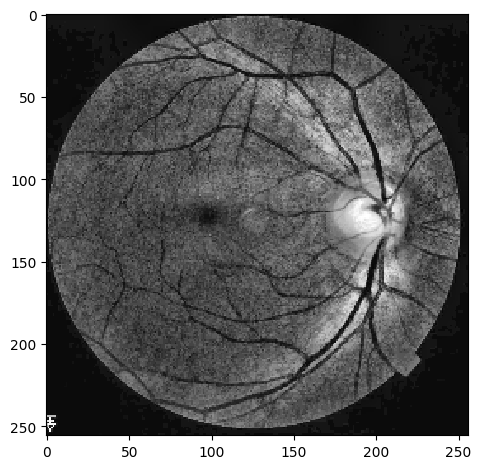

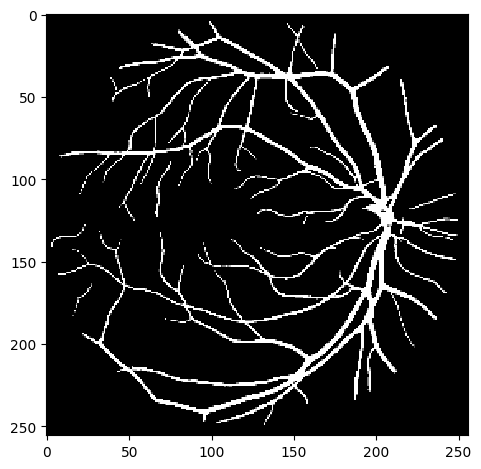

In [ ]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt

ix = random.randint(0, len(train_x))
imshow(train_x[ix])
plt.show()

imshow(train_y[ix])
plt.show()

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
import tensorflow as tf

inputs = Input((256,256,1))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 256, 256, 1)          0         ['input_2[0][0]']             
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         160       ['lambda_1[0][0]']            
                                                                                                  
 dropout_9 (Dropout)         (None, 256, 256, 16)         0         ['conv2d_19[0][0]']           
                                                                                            

In [ ]:
results = model.fit(train_x, train_y,epochs=5)
#      callbacks=[checkpointer])

Epoch 1/5
75/75 [==============================] - 52s 379ms/step - loss: 0.2152 - accuracy: 0.9226
Epoch 2/5
75/75 [==============================] - 29s 392ms/step - loss: 0.1409 - accuracy: 0.9436
Epoch 3/5
75/75 [==============================] - 30s 396ms/step - loss: 0.1224 - accuracy: 0.9496
Epoch 4/5
75/75 [==============================] - 30s 395ms/step - loss: 0.1106 - accuracy: 0.9539
Epoch 5/5
75/75 [==============================] - 30s 401ms/step - loss: 0.1000 - accuracy: 0.9577


In [ ]:
model.save("/content/drive/MyDrive/model_aug.h5")
model.save("/content/drive/MyDrive/model_aug.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model_aug.h5',safe_mode=False)

In [ ]:
config = model.get_config()
print(config["layers"][0]["config"]["batch_input_shape"])

(None, 256, 256, 1)


In [ ]:
test = readImage("/content/drive/MyDrive/IIC/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Original/12_A.png",**args)
res = readMask("/content/drive/MyDrive/IIC/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test/Ground truth/12_A.png",args['resize_dim'])

In [ ]:
args = {
    'preprocess': False,
    'functions': None,
    'resize_dim': (256, 256),
    'clahe_params': None,
    'tophat_params': None
}
test = readImage('/content/drive/MyDrive/image-[0.95503443].png',**args)

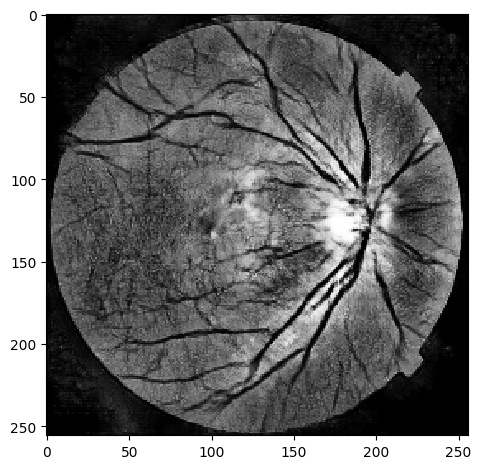

In [ ]:
imshow(test)
plt.show()
# print(test)


1/1 [==============================] - 3s 3s/step


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


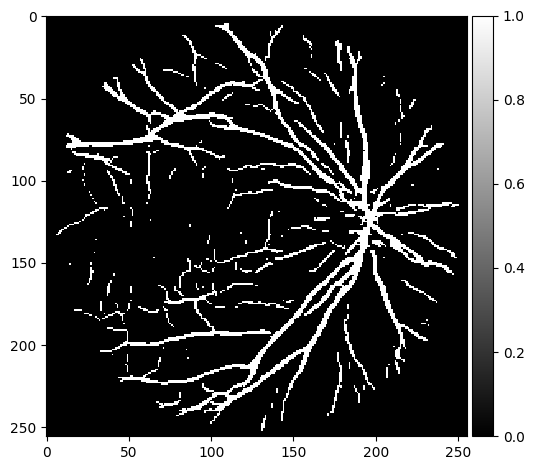

In [ ]:
img = np.expand_dims(test[:,:,0], axis=0)
pred = model.predict(img)*255
mask = np.where(pred[0] > 128, 1 , 0).astype(int)
imshow(mask,cmap='gray')

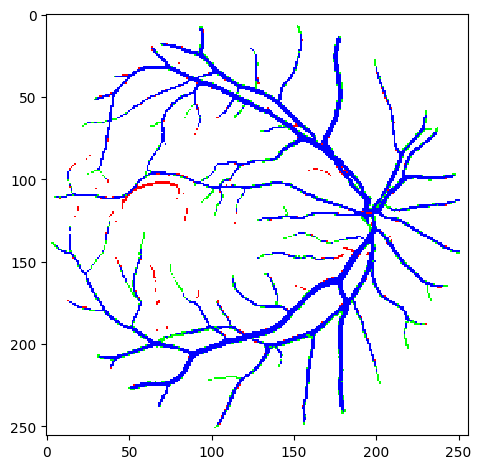

In [ ]:
from PIL import Image

def numpy_to_image(numpy_array):
    numpy_array = numpy_array * 255
    image = Image.fromarray(numpy_array.astype(np.uint8))
    return image

def compare_binary_images(reference, extract):

    height, width = reference.shape[:2]
    C = np.zeros(shape=(height, width, 3))

    for i in range(height):
        for j in range(width):
            ref_val = reference[i][j]
            extract_val = extract[i][j]
            if ref_val == extract_val == 0:
                C[i][j] = [1, 1, 1]  # White for matching black pixels
            elif ref_val == 0:
                C[i][j] = [0, 1, 0]  # Green for black pixels in reference only
            elif extract_val == 0:
                C[i][j] = [1, 0, 0]  # Red for black pixels in extract only
            else:
                C[i][j] = [0, 0, 1]  # White for matching white pixels
    return C


reference = mask
extract = res

C = compare_binary_images(reference, extract)
imshow(C)

In [ ]:
def compare(image1, image2):
    image1 = np.array(image1).astype(int)
    image2 = np.array(image2).astype(int)

    tp = np.sum(np.logical_and(image1 == 1, image2 == 1))
    tn = np.sum(np.logical_and(image1 == 0, image2 == 0))
    fp = np.sum(np.logical_and(image1 == 0, image2 == 1))
    fn = np.sum(np.logical_and(image1 == 1, image2 == 0))

    return tp, tn, fp, fn

def calculate_metrics(tp, tn, fp, fn):
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
    return sensitivity, specificity, accuracy

tp, tn, fp, fn = compare(res, mask)
print("True Positives (TP):", tp)
print("True Negatives (TN):", tn)
print("False Positives (FP):", fp)
print("False Negatives (FN):", fn)

sensitivity, specificity, accuracy = calculate_metrics(tp, tn, fp, fn)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)

True Positives (TP): 4430
True Negatives (TN): 59985
False Positives (FP): 715
False Negatives (FN): 406
Sensitivity: 0.9160463192721258
Specificity: 0.9882207578253707
Accuracy: 0.9828948974609375


In [ ]:
def calculate_average_metrics(arr1,arr2):
    total_tp, total_tn, total_fp, total_fn = 0, 0, 0, 0
    num_images = len(arr1)

    for i in tqdm(range(num_images)):
        tp, tn, fp, fn = compare(arr1[i], arr2[i])
        total_tp += tp
        total_tn += tn
        total_fp += fp
        total_fn += fn
    sensitivity, specificity, accuracy = calculate_metrics(total_tp, total_tn, total_fp, total_fn)

    print("\n")
    print("True Positives (TP):", total_tp)
    print("True Negatives (TN):", total_tn)
    print("False Positives (FP):", total_fp)
    print("False Negatives (FN):", total_fn)
    print("Sensitivity:", sensitivity)
    print("Specificity:", specificity)
    print("Accuracy:", accuracy)

In [ ]:
test_path = "/content/drive/MyDrive/IIC/FIVES A Fundus Image Dataset for AI-based Vessel Segmentation/test"
test_x, test_y = load_data(test_path,args)

100%|██████████| 200/200 [01:44<00:00,  1.92it/s]


In [ ]:
print(test_x.shape)
print(test_y.shape)

(200, 256, 256, 1)
(200, 256, 256, 1)


In [ ]:
preds = model.predict(test_x)*255
masks = []
for i in range(len(preds)):
  masks.append(np.where(preds[i] > 128, 1 , 0).astype(int))
masks = np.array(masks)

7/7 [==============================] - 2s 323ms/step


In [ ]:
calculate_average_metrics(masks, test_y)

100%|██████████| 200/200 [00:00<00:00, 1553.72it/s]



True Positives (TP): 725442
True Negatives (TN): 12118832
False Positives (FP): 121375
False Negatives (FN): 141551
Sensitivity: 0.8367333992315971
Specificity: 0.9900839095286542
Accuracy: 0.9799403381347657
